<a href="https://colab.research.google.com/github/andrecsq/trabalho_simulacao/blob/main/simulacao_implementacao_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Solução Analítica

In [ ]:
beta = 2
gamma = 1.5
total_population = 100
time_steps = 50
initial_infected = 1

I_inf = (1- gamma/beta)*total_population
V = I_inf/initial_infected - 1
x = beta - gamma

def I(t):
  return I_inf / (1 + V*np.exp(-x*t) )

infected_analytic = np.array([I(t) for t in range(0, time_steps)])
susceptible_analytic = total_population - infected_analytic

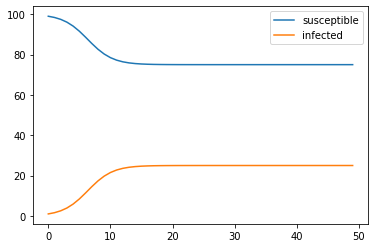

In [ ]:
plt.plot(susceptible_analytic, label='susceptible')
plt.plot(infected_analytic, label='infected')
plt.legend()

## Implementação Eventos

In [ ]:
import queue
from dataclasses import dataclass, field

@dataclass(order=True)
class Event:
  time: float
  event_type: str=field(compare=False)
  target: int=field(compare=False)
  source: int=field(compare=False, default=None)

@dataclass
class Node:
  id: int
  is_infected: bool
  rec_time: float

In [ ]:
def initialize_population_state(total_population):
  pop_state = []
  for i in range(total_population):
    ns = Node(i, False, 0)
    pop_state.append(ns)
  return pop_state

def initialize_queue(total_population, initial_infected):
  q = queue.PriorityQueue()
  for i in range(initial_infected):
    transmission_event = Event(0, 'transmission', i, i)
    q.put(transmission_event)
  return q

In [ ]:
def process_trans_SIS(time, node_list, q, beta, gamma, target_node):
  
  # Infect the node and set recuperation time
  target_node.is_infected = True
  rec_time = time + np.random.exponential(gamma)
  target_node.rec_time = rec_time
  node_list[target_node.id] = target_node

  # Create the cure event
  cure_event = Event(rec_time, 'cure', target_node.id)
  q.put(cure_event)

  # Infect all neighbours
  source_node = target_node # Target of transmission is now the source of transmission
  for neighbour in node_list:
    if neighbour.id != source_node.id:
      target_node = neighbour # The neighbour is the new recipient
      find_next_trans_SIS(time, node_list, q, beta, gamma, source_node, target_node)

# Checks if the target WILL BE susceptible and the source will be infected at the time of the contamination
def find_next_trans_SIS(time, node_list, q, beta, gamma, source_node, target_node):
  # Checks if: target_rec_time <= transmission_time < source_rec_time
  if target_node.rec_time < source_node.rec_time:
    # O evento de infecção só "conta" depois que o target está suscetível
    transmission_time = max(time, target_node.rec_time) + np.random.exponential(beta)
    if transmission_time < source_node.rec_time:
      new_trans = Event(transmission_time, 'transmission', target_node.id, source_node.id)
      q.put(new_trans)

def process_rec_SIS(time, node_list, target_node):
  node_list[target_node.id].is_infected = False 
  events.append(Event(time, 'cure', target_node.id))

def get_number_infected(node_list):
  return sum([node.is_infected for node in node_list])

In [ ]:
events = []
  
def simulate_epidemic(beta, gamma, total_population, initial_infected, max_time):
  node_list = initialize_population_state(total_population)
  q = initialize_queue(total_population, initial_infected)
  times = []
  amount_infected = []


  null_infections = 0
  while not q.empty():
    e = q.get()
    
    if e.time > max_time:
      return times, amount_infected
    if e.event_type == 'cure':
      target_node = node_list[e.target]
      process_rec_SIS(e.time, node_list, target_node)
    elif e.event_type == 'transmission':
      target_node = node_list[e.target]
      source_node = node_list[e.source]
      if not target_node.is_infected:
        process_trans_SIS(e.time, node_list, q, beta, gamma, target_node)
        events.append(Event(e.time, 'transmission', e.target, e.source))
      find_next_trans_SIS(e.time, node_list, q, beta, gamma, source_node, target_node)

    times.append(e.time)
    infected = get_number_infected(node_list)
    amount_infected.append(infected)

    if infected == 0:
      break
  
  return times, amount_infected

In [ ]:
total_population = 500
initial_infected = 10
max_time = 0.5

beta = 0.5
gamma = 0.3

In [ ]:
times, amount_infected = simulate_epidemic(beta, 
                                          gamma, 
                                          total_population,
                                          initial_infected,
                                          max_time)

In [ ]:
#for event in events:
  #print(event)

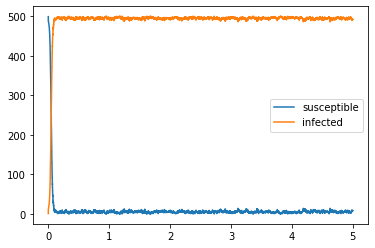

In [ ]:
amount_susceptible = total_population - np.array(amount_infected)
new_times = np.array(times) * 10
plt.plot(new_times, amount_susceptible, label='susceptible')
plt.plot(new_times, amount_infected, label='infected')
plt.legend()

In [ ]:
# for event in events:
#   print(event)

In [ ]:
# Input: Network G, transmission rate per edge τ, recovery rate γ, set of index node(s)
#   initial infecteds, and maximum time tmax.
# Output: t: list of times and I: list containing number infected at each time.

# function fast_SIS(G,τ, γ, initial infecteds, tmax)
#   initialise Q, node statuses and return variables as in fast SIR, but include a source for infections with recovery time 0.
#   while Q is not empty do
#     Event ← earliest remaining event in Q
#     if Event.action is transmit then
#       if Event.node.status is susceptible then
#         process_trans_SIS(G, Event.node, Event.time, τ, γ, times, S, I, Q, tmax) 
#       find_next_trans_SIS(Q, Event.source, Event.node, t)  # needed for SIS model <--- Não entendi isso. Por que ele transmite de novo?
#     else
#       process rec_SIS(Event.node, t, S, I) # Apenas recupera o node
#   return times, S, I

# function process_trans_SIS(G, u, t, τ, γ, times, S, I, Q, tmax)
#   append_times, S, and I with t, S.last−1, and I.last+1
#   u.status ← infected
#   u.rec_time ← t+exponential variate(γ)
#   if u.rec_time < tmax then
#     newEvent ← {node: u, time: u.rec_time, action: recover}
#     push(Q, newEvent)
#   for v in G.neighbours(u) do
#     find_next_trans_SIS(Q, t, τ, u, v, tmax)

# function find_next_trans_SIS(Q, t, τ, source, target, tmax)
#   - Se o alvo se recuperar antes da fonte
#   if target.rec_time < source.rec_time then
#     transmission_time = max(t, target.rec_time)+exponential_variate(τ) 
#     if transmission_time < source.rec_time then # E o tempo da transmissão é antes da fonte se recuperar
#       newEvent ← {node: target, time: transmission_time, action: transmit, source: source} 
#       push(Q, newEvent) # cria novo evento de transmissão

# function process_rec_SIS(u, times, S, I)
#   append times, S, and I with t, S.last+1, and I.last−1
#   u.status ← susceptible